# Project 2 - Clustering with unrelated Features

High dimensionality (data containing a lot of features/predictors) is another aspect of big data. In the case of clustering, data containing a lot of *unrelated features* which does not contribute to the separation of the samples. *Relevant features* are features which separates samples into clusters. High dimensionality is said to make clustering more difficult since cluster structure might be lost in higher dimensions due to *curse of dimensionality*.


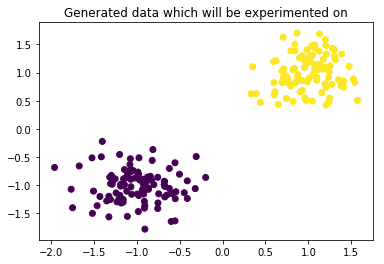

In [3]:
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import os
from itertools import combinations 
import random
from itertools import product, permutations, combinations_with_replacement, combinations, dropwhile

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

Random_state = 2019
np.random.seed(10)
random.seed(Random_state)
#np.random.RandomState(seed=Random_state)




#Generate data which will be experimented on
X, y = make_blobs(n_samples=[100,100], centers=[[-1,-1],[1,1]],
                  cluster_std= [0.3,0.3],n_features=2, random_state=Random_state)


X_original = X.copy()
#plt.figure(figsize=((12,10)))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Generated data which will be experimented on')
plt.show()



## Adding unrelated features 

New features can be sampled from the following distributions

- **Uniform:** :at unifrom from $[-2,2]$
    - With each addition of these type of feature, all the samples will become more equidistant and farther apart [1].
- **One Gaussian:** Where  $\mu_1=-5, \quad \sigma = 1$
    - Similiar effects will occur as with the *uniform*  but with slower effects. This is because the samples are denser around the mean of each feature and not as spread. 
- **Two Gaussian:** Half of the samples from one gaussian $\mu_1=-5 \quad \sigma = 1$ and the other half of the samples from another Gaussian $\mu_2=5 \quad \sigma = 1$. 
    - Each gaussian also contains approx half-half from each of the two original cluster.
    - This type of feature is meant to add a new structure to the data consisting of two clusters where each new cluster is a mix of the two original clusters.

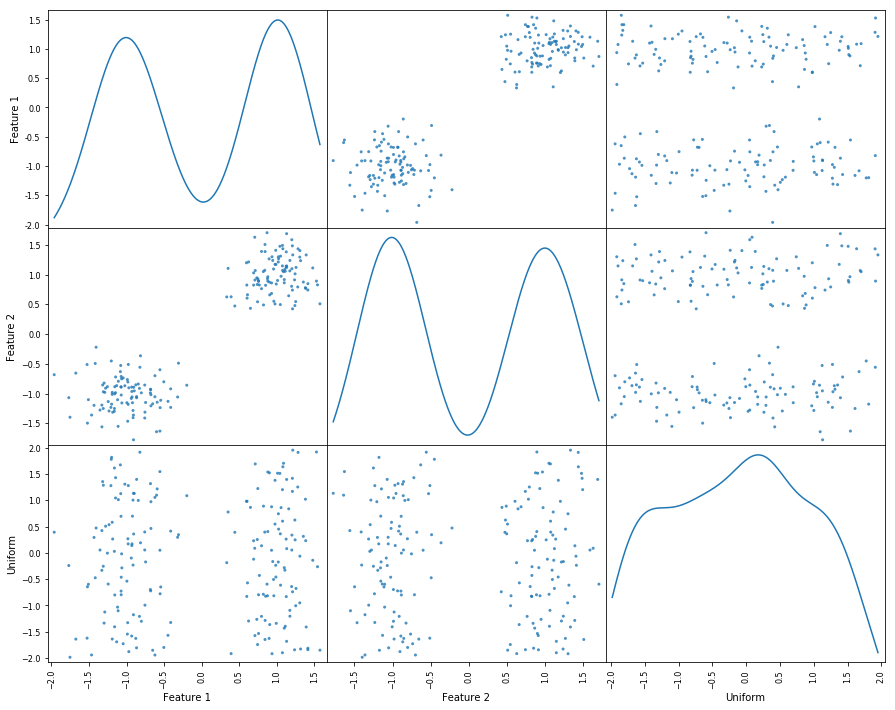

<Figure size 576x432 with 0 Axes>

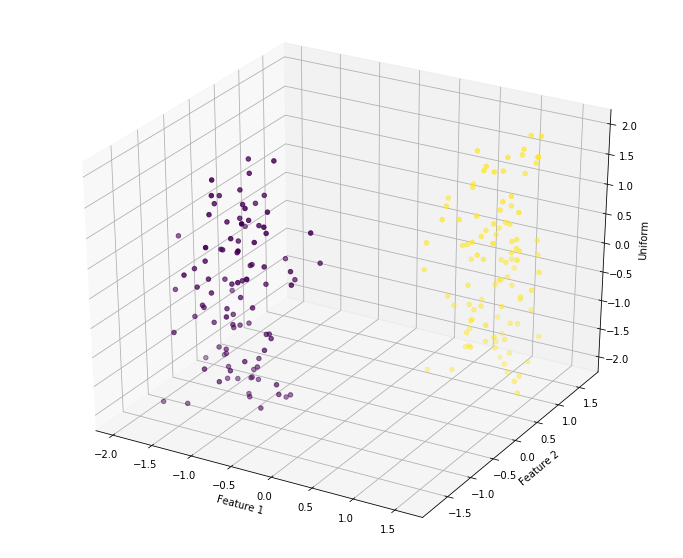

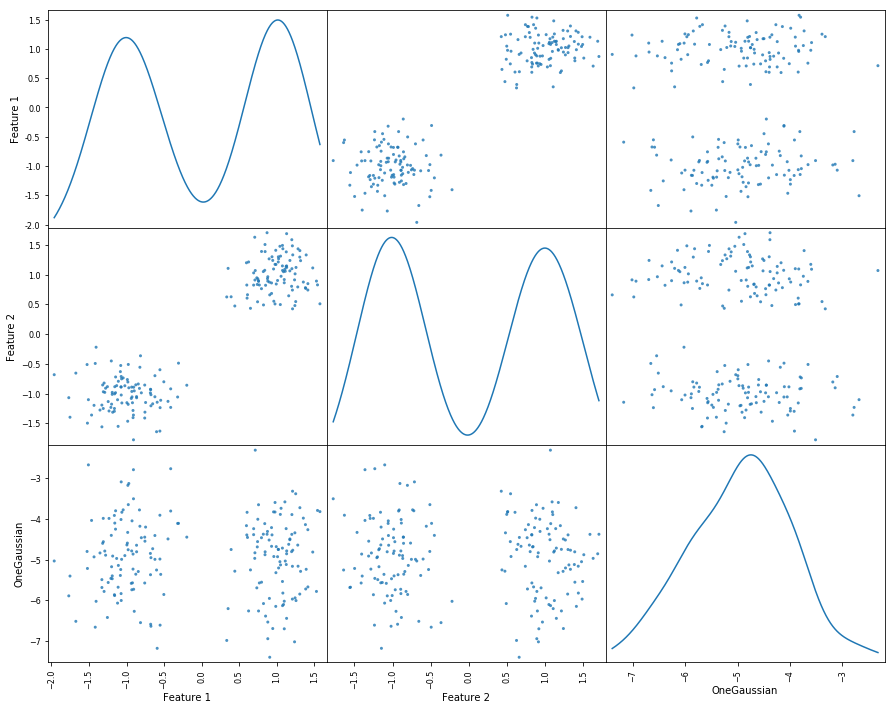

<Figure size 576x432 with 0 Axes>

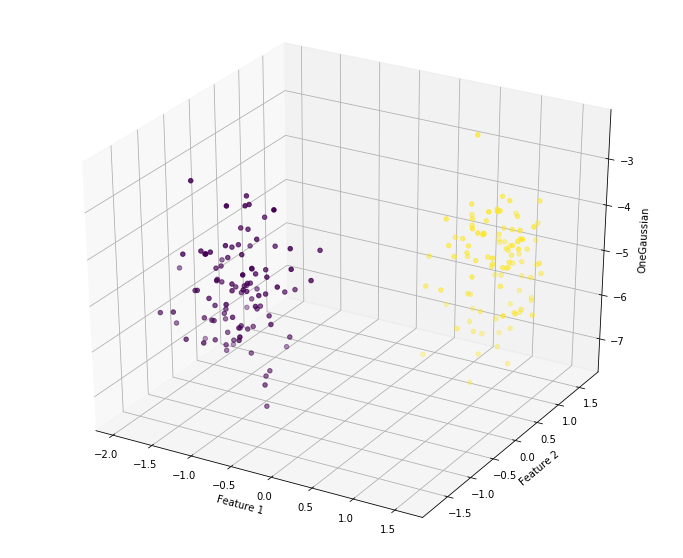

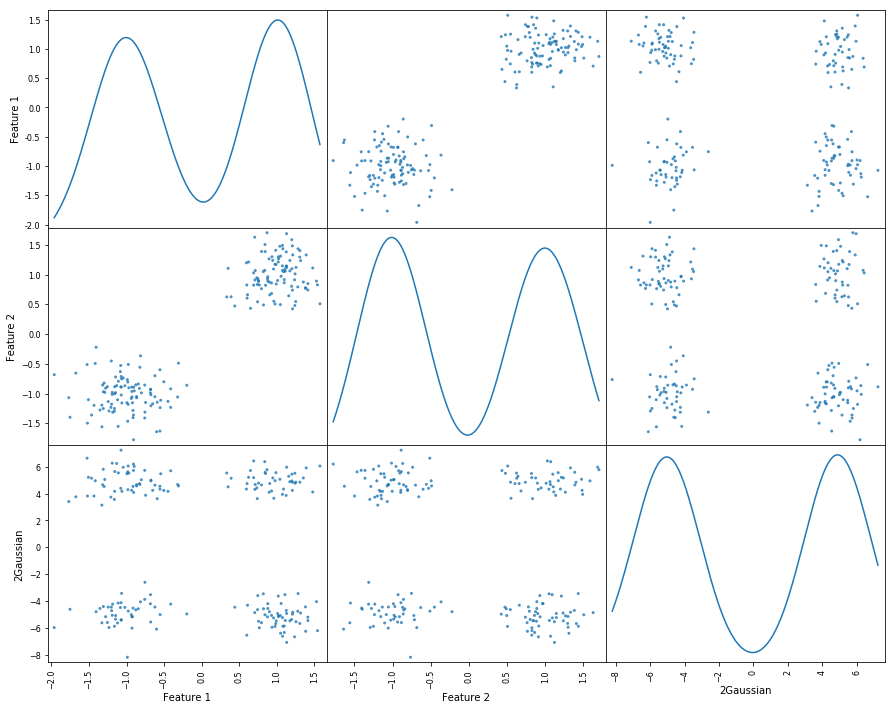

<Figure size 576x432 with 0 Axes>

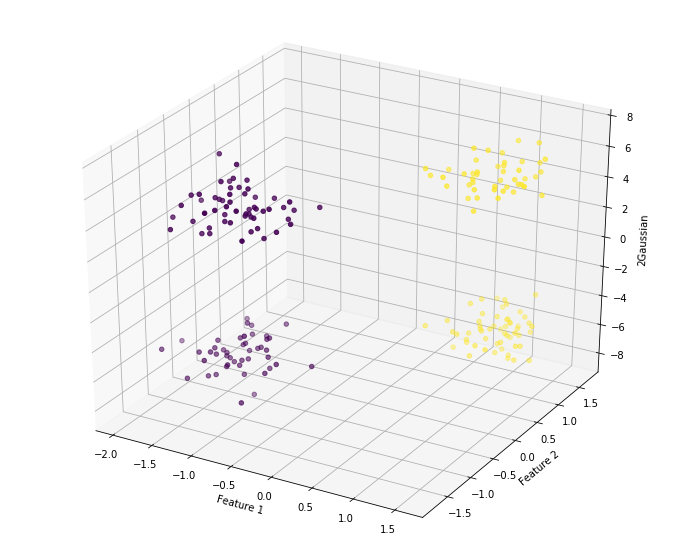

In [2]:
def addNewFeatures( typeFeature, numberOfUnrelatedFeaturesAdded):
    #print(X.shape)  #Let UFi  denote unrelated feature number i
    X = np.copy(X_original)
    mu1 = -5
    mu2 = 5
    sigma = 1
    
    #adding more and more features
    
    
    if(typeFeature=='Uniform'): 
        unrelatedFeatures = np.asarray([(np.random.uniform(-2,2,len(X)))])
        for i in range(1,numberOfUnrelatedFeaturesAdded):
            unrelatedFeatures = np.concatenate((unrelatedFeatures, np.asarray([(np.random.uniform(-2,2,len(X)))])), axis=0)      
    elif(typeFeature=='OneGaussian'):
        unrelatedFeatures = np.asarray([(np.random.normal(mu1, sigma, len(X)))])
        for i in range(1,numberOfUnrelatedFeaturesAdded):
            unrelatedFeatures = np.concatenate((unrelatedFeatures, np.asarray([(np.random.normal(mu1, sigma, len(X)))])), axis=0) 
    elif(typeFeature=='2Gaussian'):
        unrelatedFeatures = np.asarray([np.concatenate((np.random.normal(mu1, sigma, int(len(X)/2)), np.random.normal(mu2, sigma, int(len(X)/2))), axis=0)])
        for i in range(1,numberOfUnrelatedFeaturesAdded):
            unrelated_feature = np.asarray([np.concatenate((np.random.normal(mu1, sigma, int(len(X)/2)), np.random.normal(mu2, sigma, int(len(X)/2))), axis=0)])
            unrelatedFeatures = np.concatenate((unrelatedFeatures, unrelated_feature), axis=0) 
    return X if numberOfUnrelatedFeaturesAdded == 0 else np.concatenate((X, unrelatedFeatures.T), axis=1)

FeatureTypes = [
               'Uniform'  , 
               'OneGaussian',
               '2Gaussian' 
              ]

for featureType in FeatureTypes:
    
    X = addNewFeatures(featureType, 1)
    df_spm = pd.DataFrame(data=X, columns=['Feature 1', 'Feature 2', featureType])
    scatter_matrix(df_spm, alpha=0.8, figsize=(15, 12), diagonal='kde');
    plt.show()
    plt.figure(figsize=(8, 6))
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:,2], c=y)

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel(featureType)
    plt.show()



## Pairwise distances

Pairwise distance is the distance between two samples. The cell below will graph pairwise distances for all of the samples by letting the x-axis be the distance and the y axis the number of occurences of that distance. There is in total 200 samples which will give in total $\sum^{200}_{i=1}i =20100$ unique distances. Excluding the distances to the sample itself will give $20100 - 200 = 19900$.

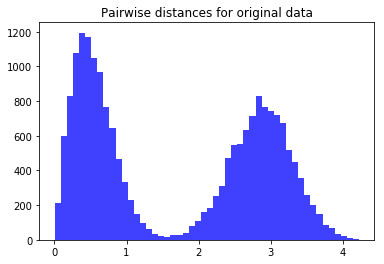

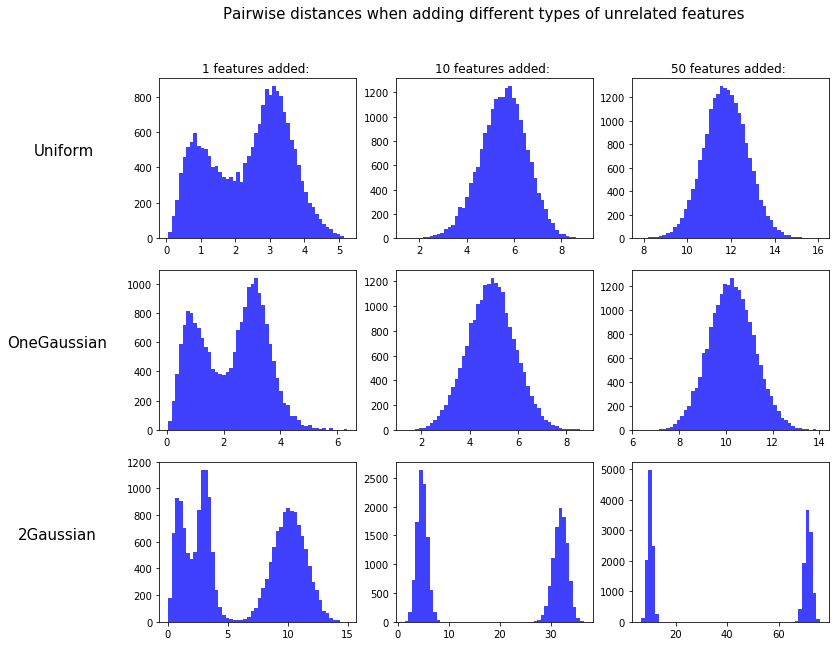

In [3]:
from sklearn.metrics import pairwise_distances

FeatureType = [
               'Uniform'  , 
               'OneGaussian',
               '2Gaussian' 
              ]

AmountOfUnrelated = [1,
                     10,
                     50
                    ]


Dist_matrix = pairwise_distances(X_original)

#Modify the distance matrix so only the upper triangle part gets pulled out into list
pairwiseDistances = np.delete(np.triu(Dist_matrix).flatten(),np.argwhere(np.triu(Dist_matrix).flatten()==0))

n, bins, patches = plt.hist(pairwiseDistances, 50, density=None, facecolor='b', alpha=0.75)

plt.title('Pairwise distances for original data')
plt.show()







#Plot the pairwise distances when adding unrelated features
plot_num = 1
plt.figure(figsize=(12,10))
plt.suptitle('Pairwise distances when adding different types of unrelated features',size=15)

for i_featureType,TypeOfUnrelated in enumerate(FeatureType):
    for amountOfUnrelatedFeatures in AmountOfUnrelated:
        data = addNewFeatures(TypeOfUnrelated, amountOfUnrelatedFeatures)

        Dist_matrix = pairwise_distances(data)
        #print(len(np.delete(np.triu(Dist_matrix).flatten(),np.argwhere(np.triu(Dist_matrix).flatten()==0))))
        #Modify the distance matrix so only the upper triangle part gets pulled out into list
        pairwiseDistances = np.delete(np.triu(Dist_matrix).flatten(),np.argwhere(np.triu(Dist_matrix).flatten()==0))
    
        #Plotting
        
        plt.subplot(len(AmountOfUnrelated), len(FeatureType), plot_num)
        if i_featureType == 0:
            plt.title( str(amountOfUnrelatedFeatures)+' features added: ', size=12)
        if (plot_num % len(FeatureType)-1 == 0): 
            plt.ylabel(TypeOfUnrelated ,rotation=0, size=15, labelpad = 70)
            
        n, bins, patches = plt.hist(pairwiseDistances, 50, density=None, facecolor='b', alpha=0.75)
    
        
        #plt.title('Histogram of pairwise distance ' +  str(amountOfUnrelatedFeatures) +' unrelated features')
        #plt.xlabel('Amount of unrelated features')
        #plt.ylabel('Occurences', rotation=0, labelpad=30)
        plot_num += 1
    
plt.show()


The pairwise distance for the original data clearly shows two well separated dense regions which represent the two generated clusters. It can be seen that the addition of *uniform* and *one gaussian* features will make all the samples more equidistant by making the distances between all the samples greater. Each addition of *2Gaussian* will separate two clusters further apart. However, it is known that separated clusters is not the original two cluster. will be seen in the later sections

## Remapping function

The clustering labels produced from the algorithms are arbitraty. This function will remap the class labels to the most produced accuracy. In the case of two class problem the following remapping can be done depending on which produces the most accuracy

- Either keep the current cluster labels
- Or switch each predicted label to the opposite class

In [4]:
def ReMapTwoClasses(y_true, y_pred):
    temp_accuracy = accuracy_score(y_true, y_pred)
    temp_adj = adjusted_rand_score
    swap = list(set(y_pred))
    y_remapped = list(map(lambda x: swap[1] if x==swap[0] else swap[0] if x==swap[1] else x ,y_pred))  #map (0,1)
    return y_remapped if(temp_accuracy <  accuracy_score(y_true, y_remapped)) else y_pred;






################Test the mapping function################################
#y_text = '0 0 0 1 1 1 1'
#y = [int(s) for s in y_text.split(' ')]

#print(y) 
#y_pred_text = '1 1 1 0 0 0 0' 
#y_pred_ML = [int(s) for s in y_pred_text.split(' ')]
#print(y_pred)


#print(MapFunction(y, y_pred_ML))
#print(accuracy_score(y, y_pred))
#y_remap = ReMapTwoClasses(y, y_pred_ML)
#print(y_remap)
#print(accuracy_score(y, y_remap))
#print(accuracy_score(y, MapFunction(y, y_pred_ML)))

## Clustering algorithms

This section will test the addition of unrelated features on clustering algorithms. The algorithms tested are kmeans, Gaussian Mixture model (GMM), and Hierarchical clustering (HC).The independent variable will be the amount of extra added features to the generated data. The dependent variable will be external (Adjusted random index ) and internal (average silhoutte width) validation scores for the computed clustering. The ground truth labels for external validation will be produced from two relevant features as noted in Figure 4 before the addition of unrelated features.
<br/>
<br/>
 .The simulation will be run 10 times (transparent lines) and then averaged (black bold line) for more stable results.

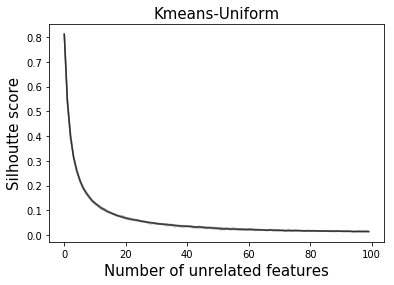

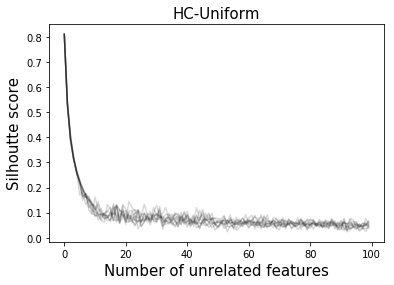

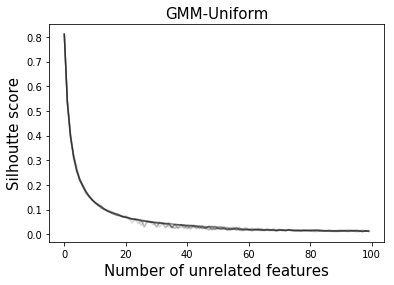

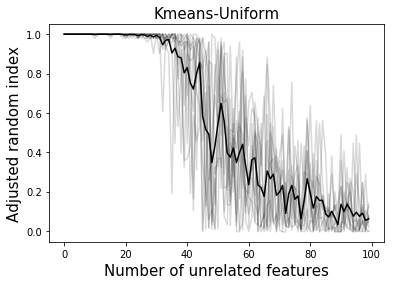

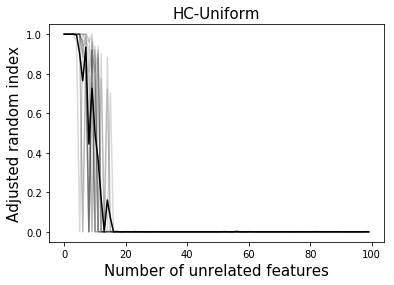

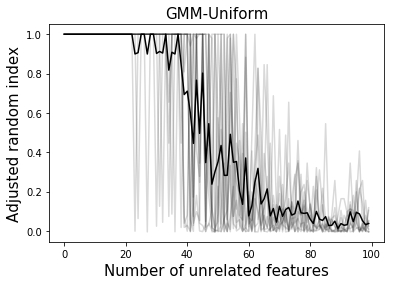

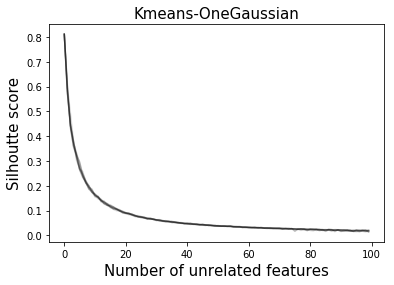

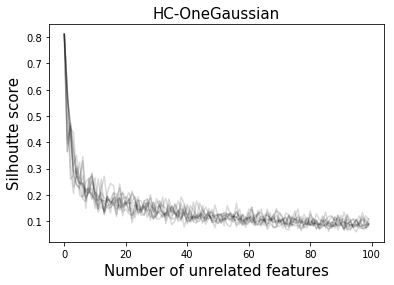

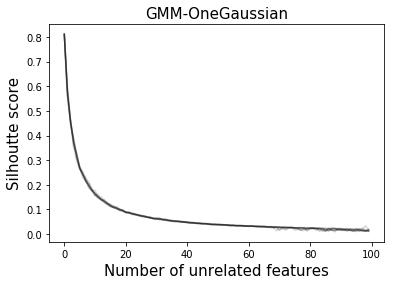

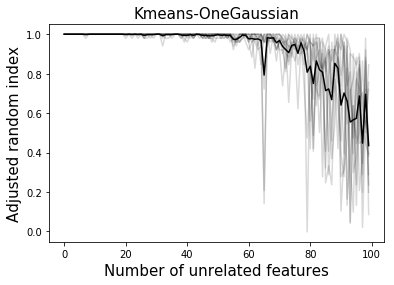

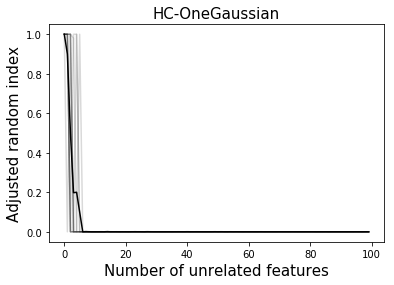

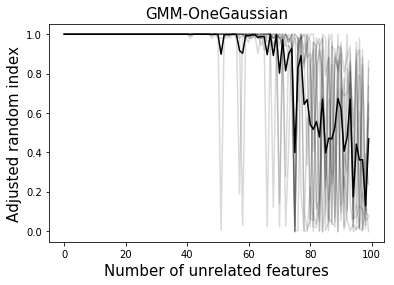

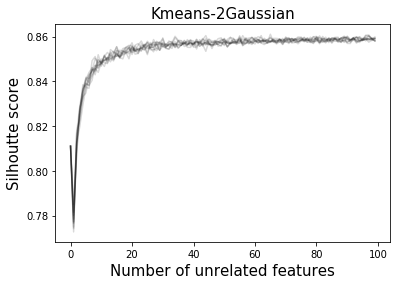

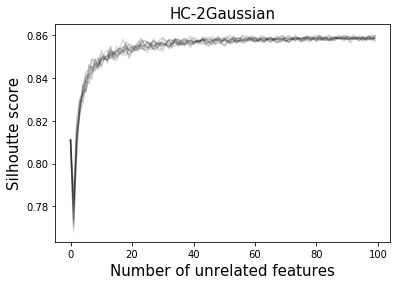

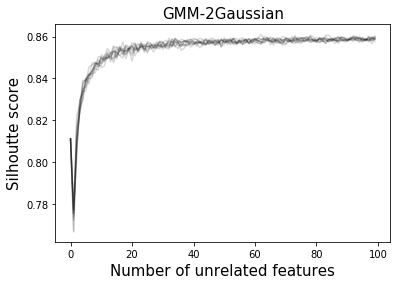

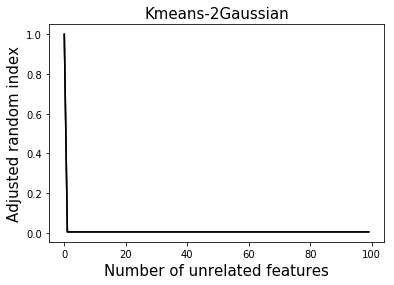

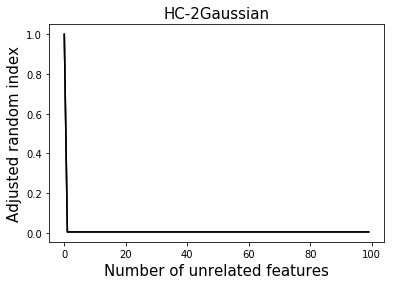

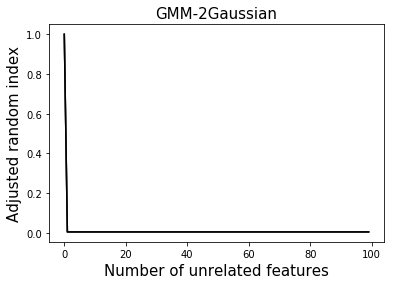

In [5]:

metrics = [
           'Silhoutte score',  
           'Adjusted random index', 
          ]

clustering_algorithms = (
    
    ('Kmeans', cluster.KMeans(n_clusters=2)),

    ('HC', cluster.AgglomerativeClustering(linkage="average", affinity="euclidean", n_clusters=2)),
    ('GMM', mixture.GaussianMixture(n_components=2, covariance_type = 'tied', max_iter=20, n_init = 5)),
    #('DBSCAN', cluster.DBSCAN(eps=0.275)),
    )

for i_simulation, typeOfUnrelatedFeature in enumerate(FeatureType):    #Loop through each unrelated feature type
    for metric in metrics: #Loop through each metric
        Measure_Dependent_varaible = metric
        for name, algorithm in clustering_algorithms:   #Loop through each clustering algorithms
            mean_adj_rand_score = []
            mean_silhoutte = []
            #plt.subplot(len(simulations), len(clustering_algorithms), plot_num)
            for i in range(10): #Run the simulation 10 times to average the results
            
                numberOfUnRelatedFeatures = 100
                stepInEachIteration = 1
                results_Accuracy = []
                silhoutte_mean_score = []
                Adj_rand_scores = []
                UnrelatedFEatuerIterations = []
                for unrelatedFeatureIndex in range (0,numberOfUnRelatedFeatures,stepInEachIteration):  #Perform the simulation on a clustering algorithm
                
                    X = addNewFeatures(typeOfUnrelatedFeature, unrelatedFeatureIndex)
                    algorithm.fit(X)
                    if hasattr(algorithm, 'labels_'):
                        y_pred = algorithm.labels_.astype(np.int)
                    else:
                        y_pred = algorithm.predict(X)
            
                    #Remapping - Either switch labeling of samples or stay same depending. This depends on which produces most acc
                    y_pred_remapped = ReMapTwoClasses(y, y_pred)
                
                    #Save scores
                    results_Accuracy.append(accuracy_score(y, y_pred_remapped))
                    silhoutte_mean_score.append(silhouette_score(X, y_pred))
                    UnrelatedFEatuerIterations.append(unrelatedFeatureIndex)
                    Adj_rand_scores.append(adjusted_rand_score(y,y_pred_remapped))
            
                mean_adj_rand_score.append(np.array(Adj_rand_scores))
                mean_silhoutte.append(np.array(silhoutte_mean_score))  
                
                
                
                if metric == 'Adjusted random index':
                    plt.plot(UnrelatedFEatuerIterations,Adj_rand_scores, label='yo', alpha=0.15,c ='k')
                    plt.title(name + '-' + typeOfUnrelatedFeature, size=15)
                    plt.xlabel('Number of unrelated features', size=15)
                    plt.ylabel(metric, size=15)
                elif metric == 'Silhoutte score':
                    plt.plot(UnrelatedFEatuerIterations,silhoutte_mean_score, label='yo', alpha=0.15,c ='k')
                    plt.title(name + '-' + typeOfUnrelatedFeature, size=15)
                    plt.xlabel('Number of unrelated features', size=15)
                    plt.ylabel(metric, size=15)

            mean_adj_rand_score = np.asarray(mean_adj_rand_score)
            mean_silhoutte_score = np.asarray(mean_silhoutte)
            #print(mean_adj_rand_score.shape)
            #print(np.mean(mean_adj_rand_score,axis=0))
            if Measure_Dependent_varaible == 'Adjusted random index':
                plt.plot(UnrelatedFEatuerIterations,np.mean(mean_adj_rand_score, axis=0), label='yo', alpha=1,c ='k')
            elif Measure_Dependent_varaible == 'Silhoutte Score': 
                plt.plot(UnrelatedFEatuerIterations,np.mean(mean_silhoutte_score, axis=0), label='yo', alpha=1,c ='k')
            plt.show()


## Analysis of HC algorithm

This section will just visualize the performance of the *HC* with a dendogram. Forcing the *HC* algorithm to choose 2 clusters will put only a few samples in one of the clusters. This is why the *Adjusted random index* performs so low only after the addition of few features why the other two clustering algorihtms can handle over 20. *HC* with average linkage is also considered to capute more of the *local behavior* of the data. This is why changes in distances between samples (produced by the addition of unrelated feautres) is affecting HC more than *GMM* and *kmeans* which is considered to look more at the *global behavior*

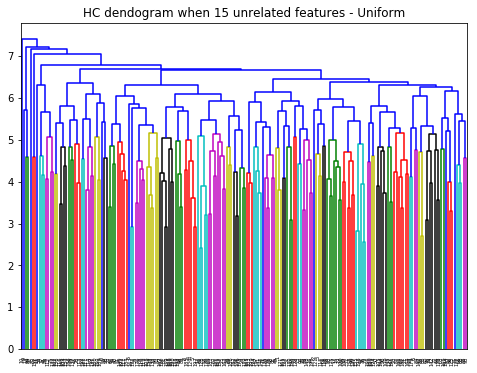

In [6]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt


def PlotDendoGram(typeOfUnrelatedFeature, numberOfUnRelatedFeature):


    X = addNewFeatures('Uniform', numberOfUnRelatedFeature)

    #ytdist = np.array(X)
    Z = hierarchy.linkage(X, 'average')
    plt.figure(figsize=(8, 6))
    plt.title('HC dendogram when 15 unrelated features - Uniform')
    dn = hierarchy.dendrogram(Z)
    
PlotDendoGram('Uniform',15)

## Conclusions

- High dimensional data tend to make samples equidistant to each other especially if most of the features are sampled at uniform
- Clustering algorithms that look at *global behavior* are more robust to deal with addition of *unrelated features.*

## References
[1] Hastie, T., Tibshirani, R., & Friedman, J. H. (2004). *The elements of statistical learning: Data mining, inference, and prediction*. New York: Springer.